# 평가조건
1. 자기만의 카메라앱 기능 구현을 완수하였다.
    - 얼굴 영역과 랜드마크를 정확하게 검출하고, 스티커 사진을 합성시키는 데 성공하였다.
2. 스티커 이미지를 정확한 원본 위치에 반영하였다.
    - 정확한 좌표계산을 통해 고양이 수염의 위치가 원본 얼굴에 잘 어울리게 출력되었다.
3. 카메라 스티커앱을 다양한 원본이미지에 적용했을 때의 문제점을 체계적으로 분석하였다.
    - 얼굴각도, 이미지 밝기, 촬영거리 등 다양한 변수에 따른 영향도를 보고서에 체계적으로 분석하였다.

# 1. 모듈 임포트

In [1]:
# 필요한 패키지 import 하기
import os 
import cv2 
import matplotlib.pyplot as plt 
import numpy as np 
import dlib 

# 2. 사진 이미지 불러오기

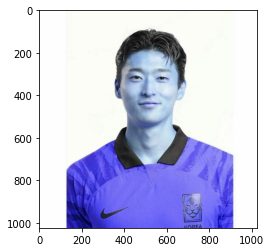

In [28]:
my_image_path = os.getenv('HOME')+'/aiffel/exploration/image/soccer.jpg' 
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옴
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관
plt.imshow(img_bgr) # 이미지를 출력하기 위해 출력할 이미지를 업로드
plt.show() # 실제 이미지를 출력(실제 출력)

- opencv는 예외적으로 BGR(파랑, 녹색, 빨강)을 사용
- opencv에서 다룬 이미지를 다른 이미지 라이브러리를 활용하여 출력하려면 색깔 보정처리를 해줘야함
- plt.imshow 이전에 RGB 이미지로 바꿔줘야함

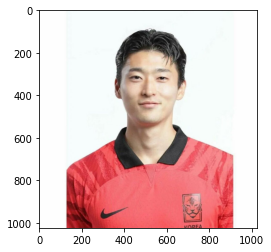

In [29]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

# 3. 얼굴 검출 & 랜드마크 검출 하기

- detector_hog를 이용해서 얼굴의 bounding box를 추출

In [30]:
detector_hog = dlib.get_frontal_face_detector()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

rectangles[[(379, 260) (646, 528)]]


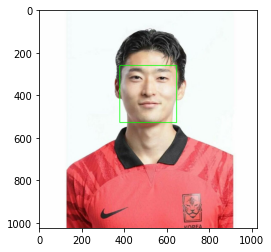

In [31]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- dlib.rectangle객체는 left(), top(), right(), bottom(), height(), width() 등의 멤버 함수를 포함하고 있음

In [32]:
display(dlib_rect.width())#얼굴 폭
display(dlib_rect.height())#얼굴 길이

268

269

## Object keypoint estimation 알고리즘을 통한 face landmark 검출

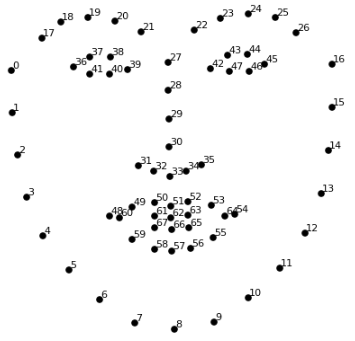

- 잘린 얼굴 이미지에서 68개의 이목구비 위치를 찾음

In [33]:
model_path = os.getenv('HOME')+ '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    # 저장한 landmark 모델의 주소를 model_path 변수에 저장
landmark_predictor = dlib.shape_predictor(model_path)
    # dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
    # landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
    # dlib.rectangle: 내부를 예측하는 박스
    # dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄

In [34]:
landmark_predictor

- landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환

In [35]:
list_landmarks = []
    # 랜드마크의 위치를 저장할 list 생성    

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
# face landmark 좌표를 저장해둡니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)
        # list_landmarks에 랜드마크 리스트를 저장

print(len(list_landmarks[0]))
    # 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
    # 각 원소는 68개의 랜드마크 위치가 나열된 list 
    # list_landmarks의 원소가 1개이므로 list_landmarks[1]을 호출하면 IndexError가 발생

68


- points 는 dlib.full_object_detection 의 객체이기 때문에 parts() 함수로 개별 위치에 접근 가능
- 조금 더 직관적인 (x, y) 형태로 접근할 수 있도록 변환
- 따라서 list_points 는 tuple (x, y) 68개로 이루어진 리스트가 완성됨
- 이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장

In [36]:
points.parts()

points[(381, 333), (383, 366), (388, 400), (396, 433), (409, 465), (430, 492), (456, 514), (489, 530), (523, 534), (557, 528), (587, 511), (613, 487), (631, 460), (641, 428), (647, 397), (650, 364), (652, 333), (409, 289), (426, 274), (449, 269), (471, 272), (493, 282), (542, 283), (564, 275), (586, 273), (606, 278), (623, 290), (518, 316), (518, 340), (518, 363), (519, 387), (493, 402), (504, 407), (518, 411), (530, 407), (542, 402), (435, 319), (450, 312), (467, 314), (480, 324), (465, 326), (448, 326), (555, 325), (569, 316), (585, 316), (598, 324), (586, 329), (570, 329), (469, 444), (490, 434), (506, 429), (519, 431), (531, 428), (547, 433), (567, 442), (548, 452), (533, 458), (519, 460), (506, 459), (490, 455), (476, 445), (506, 441), (518, 442), (531, 440), (559, 443), (532, 440), (519, 443), (507, 441)]

- points.parts()을 찍어보면 68개의 face_landmark 좌표가 찍혀 있는것을 알 수 있음

In [37]:
list_landmarks[0][:5]

[(381, 333), (383, 366), (388, 400), (396, 433), (409, 465)]

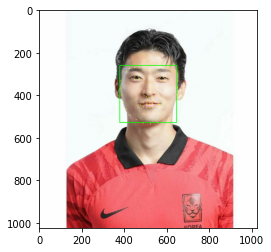

In [38]:
# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    # RGB 이미지로 전환
plt.imshow(img_show_rgb)
    # 이미지를 준비
plt.show()
    # 이미지를 출력

# 4. 스티커 적용하기
- np.where 를 사용해서 스티커를 적용
- opencv 의 cv2.addWeighted() 를 참고

In [40]:
dlib_rects

rectangles[[(379, 260) (646, 528)]]

In [41]:
# zip() : 두 그룹의 데이터를 서로 엮어주는 파이썬의 내장 함수
# dlib_rects와 list_landmarks 데이터를 엮어 주었음
# dlib_rects : 얼굴 영역을 저장하고 있는 값
# → rectangles[[(379, 260) (646, 528)]]
# list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y))


for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0] # 인중 위치
    y = landmark[30][1] - dlib_rect.height()//2 # 이미지에서 코 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2 → (437, 182-(186+1//2))
    w = h = dlib_rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수 (531-345+1) → max(x) - min(x) +1(픽셀의 수 이기 때문에 1을 더해줌 → 픽셀 수는 점 하나로도 1이 됨)
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(519, 387)
(x,y) : (519,253)
(w,h) : (268,268)


In [42]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png' # 왕관 이미지의 경로
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
print (img_sticker.shape) # 사이즈를 조정한 왕관 이미지의 차원 확인

(268, 268, 3)


In [43]:
# x,y,w,h 모두 위에서 반복문 안에서 지정해준 값임
# x는 이미지에서 코 부위의 x값 = 519
# y는 이미지에서 코 부위의 y값 = 253
# w는 얼굴 영역의 가로를 차지하는 픽셀의 수 = 268
# h는 얼굴 영역의 가로를 차지하는 픽셀의 수 = 268
refined_x = x - w // 2 # 519 - (268//2) = -93 = 385
refined_y = y - h # 253-268 = -18
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.
# 즉, refined_x, refined_y값에서 왕관 이미지가 시작됨
print (f'(x,y) : ({refined_x},{refined_y})') # 음수 발생 : 이미지 범위를 벗어남
# 우리는 현재 이마 자리에 왕관을 두고 싶은건데, 이마위치 - 왕관 높이를 했더니 이미지의 범위를 초과하여 음수가 나오는 것
# opencv는 ndarray데이터를 사용하는데, ndarray는 음수인덱스에 접근 불가하므로 스티커 이미지를 잘라 줘야 한다.

(x,y) : (385,-15)


In [44]:
# 왕관 이미지가 이미지 밖에서 시작하지 않도록 조정이 필요함
# 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
# 현재 상황에서는 -y 크기만큼 스티커를 crop 하고, top 의 x좌표와 y 좌표를 각각의 경우에 맞춰 원본 이미지의 경계 값으로 수정하면 아래와 같은 형식으로 나옵니다.
# 음수값 만큼 왕관 이미지(혹은 추후 적용할 스티커 이미지)를 자른다.
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
# 왕관 이미지를 씌우기 위해 왕관 이미지가 시작할 y좌표 값 조정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :] # refined_y가 -98이므로, img_sticker[98: , :]가 된다. (187, 187, 3)에서 (89, 187, 3)이 됨 (187개 중에서 98개가 잘려나감)
    refined_y = 0

print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (385,0)


In [45]:
# sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다.
# 예제에서는 (344,0) 부터 (344+187, 0+89) 범위의 이미지를 의미합니다.
# 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
# img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_show[0:0+89, 344:344+187]
# img_show[0:89, 344:531]
# 즉, x좌표는 344~531 / y좌표는 0~89가 됨
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# 왕관 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 왕관 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# 현재 왕관 이미지에서는 왕관과 받침대 밑의 ------ 부분이 됨
# 그렇기 때문에 0인 부분(이미지가 없는 부분)은 제외하고 적용
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 왕관 이미지에서 왕관 이미지가 없는 부분(왕관과 받침대 밑의 ------ 부분)은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(왕관 이미지에서 왕관 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(왕관 이미지)를 적용한다.
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

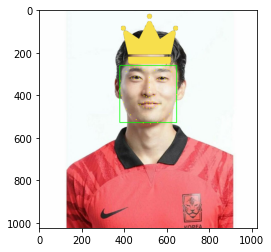

In [46]:
# 왕관 이미지를 적용한 이미지를 보여준다.
# 얼굴 영역(7-3)과 랜드마크(7-4)를 미리 적용해놓은 img_show에 왕관 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

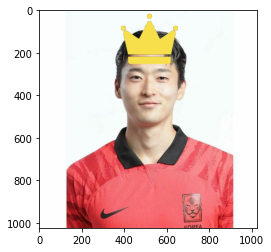

In [47]:
# 위에서 설명했으므로 생략
# 왕관 이미지
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_bgr은 7-2에서 rgb로만 적용해놓은 원본 이미지이다. 
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

## 다른 스티커 적용해보기

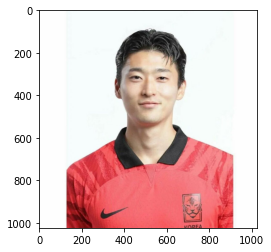

In [49]:
my_image_path = os.getenv('HOME')+'/aiffel/exploration/image/soccer.jpg' 
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옴
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) 
plt.show()

In [50]:
detector_hog = dlib.get_frontal_face_detector()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

rectangles[[(379, 260) (646, 528)]]


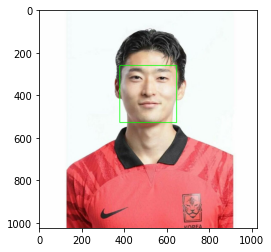

In [51]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [52]:
model_path = os.getenv('HOME')+ '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    # 저장한 landmark 모델의 주소를 model_path 변수에 저장
landmark_predictor = dlib.shape_predictor(model_path)
    # dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
    # landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
    # dlib.rectangle: 내부를 예측하는 박스
    # dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄

In [53]:
list_landmarks = []
    # 랜드마크의 위치를 저장할 list 생성    

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
# face landmark 좌표를 저장해둡니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)
        # list_landmarks에 랜드마크 리스트를 저장

print(len(list_landmarks[0]))
    # 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
    # 각 원소는 68개의 랜드마크 위치가 나열된 list 
    # list_landmarks의 원소가 1개이므로 list_landmarks[1]을 호출하면 IndexError가 발생

68


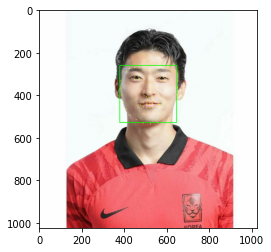

In [54]:
# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    # RGB 이미지로 전환
plt.imshow(img_show_rgb)
    # 이미지를 준비
plt.show()
    # 이미지를 출력

In [55]:
# zip() : 두 그룹의 데이터를 서로 엮어주는 파이썬의 내장 함수
# dlib_rects와 list_landmarks 데이터를 엮어 주었음
# dlib_rects : 얼굴 영역을 저장하고 있는 값
# → rectangles[[(379, 260) (646, 528)]]
# list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y))


for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0] # 인중 위치
    y = landmark[30][1] - dlib_rect.height()//2 # 이미지에서 코 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2 → (437, 182-(186+1//2))
    w = h = dlib_rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수 (531-345+1) → max(x) - min(x) +1(픽셀의 수 이기 때문에 1을 더해줌 → 픽셀 수는 점 하나로도 1이 됨)
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(519, 387)
(x,y) : (519,253)
(w,h) : (268,268)


In [56]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/santa-hat.png' # 왕관 이미지의 경로
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
print (img_sticker.shape) # 사이즈를 조정한 왕관 이미지의 차원 확인

(268, 268, 3)


In [57]:
# x,y,w,h 모두 위에서 반복문 안에서 지정해준 값임
# x는 이미지에서 코 부위의 x값 = 519
# y는 이미지에서 코 부위의 y값 = 253
# w는 얼굴 영역의 가로를 차지하는 픽셀의 수 = 268
# h는 얼굴 영역의 가로를 차지하는 픽셀의 수 = 268
refined_x = x - w // 2 # 519 - (268//2) = -93 = 385
refined_y = y - h # 253-268 = -18
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.
# 즉, refined_x, refined_y값에서 왕관 이미지가 시작됨
print (f'(x,y) : ({refined_x},{refined_y})') # 음수 발생 : 이미지 범위를 벗어남
# 우리는 현재 이마 자리에 왕관을 두고 싶은건데, 이마위치 - 왕관 높이를 했더니 이미지의 범위를 초과하여 음수가 나오는 것
# opencv는 ndarray데이터를 사용하는데, ndarray는 음수인덱스에 접근 불가하므로 스티커 이미지를 잘라 줘야 한다.

(x,y) : (385,-15)


In [58]:
# 왕관 이미지가 이미지 밖에서 시작하지 않도록 조정이 필요함
# 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
# 현재 상황에서는 -y 크기만큼 스티커를 crop 하고, top 의 x좌표와 y 좌표를 각각의 경우에 맞춰 원본 이미지의 경계 값으로 수정하면 아래와 같은 형식으로 나옵니다.
# 음수값 만큼 왕관 이미지(혹은 추후 적용할 스티커 이미지)를 자른다.
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
# 왕관 이미지를 씌우기 위해 왕관 이미지가 시작할 y좌표 값 조정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :] # refined_y가 -98이므로, img_sticker[98: , :]가 된다. (187, 187, 3)에서 (89, 187, 3)이 됨 (187개 중에서 98개가 잘려나감)
    refined_y = 0

print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (385,0)


In [59]:
# sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다.
# 예제에서는 (344,0) 부터 (344+187, 0+89) 범위의 이미지를 의미합니다.
# 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
# img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_show[0:0+89, 344:344+187]
# img_show[0:89, 344:531]
# 즉, x좌표는 344~531 / y좌표는 0~89가 됨
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# 왕관 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 왕관 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# 현재 왕관 이미지에서는 왕관과 받침대 밑의 ------ 부분이 됨
# 그렇기 때문에 0인 부분(이미지가 없는 부분)은 제외하고 적용
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 왕관 이미지에서 왕관 이미지가 없는 부분(왕관과 받침대 밑의 ------ 부분)은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(왕관 이미지에서 왕관 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(왕관 이미지)를 적용한다.
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

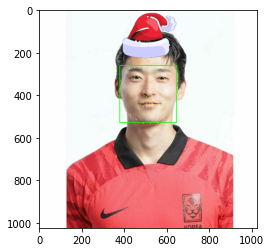

In [60]:
# 왕관 이미지를 적용한 이미지를 보여준다.
# 얼굴 영역(7-3)과 랜드마크(7-4)를 미리 적용해놓은 img_show에 왕관 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

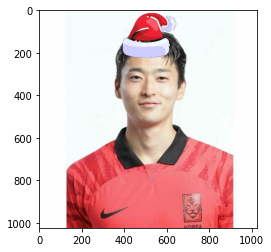

In [61]:
# 위에서 설명했으므로 생략
# 왕관 이미지
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_bgr은 7-2에서 rgb로만 적용해놓은 원본 이미지이다. 
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

## 전체 회고
- CV는 뭔가 어려운거 같다고 느껴진다.
- 이번 exploration은 그냥 베이스라인 코드대로 따라만 한 것 같다.
- 아직 제대로 된 감이 안잡힌 느낌이다.
- 사실 이렇게 한게 맞는건지도 의문이 든다.